# 7章 効果検証：機械学習にもとづいた施策の成果を判断する

## 7.2 因果効果の推定

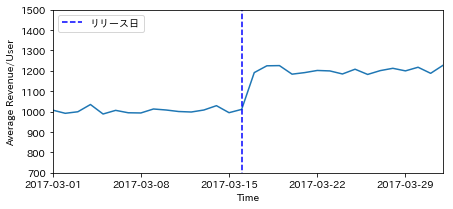

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import datetime as dt

x = pd.date_range(dt.datetime(2017, 3, 1), dt.datetime(2017, 4, 1))
y = np.random.randn(len(x)) * 20 + 1000
y2 = np.random.randn(len(x)) * 20 + 1000

y_change = list(np.zeros(int(len(x)/2))) + list(np.ones(int(len(x)/2)) + 200)
y_change2 = list(np.zeros(int(len(x)/2))) + list(np.ones(int(len(x)/2)).cumsum() * 7)

plt.figure(figsize=(7, 3))
plt.plot(x, y + y_change)
plt.ylim(700, 1500)
plt.xlabel('Time')
plt.xlim(x[0], x[-1])
plt.ylabel('Average Revenue/User')
plt.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--', label='リリース日')
plt.legend(loc='upper left')
plt.show()

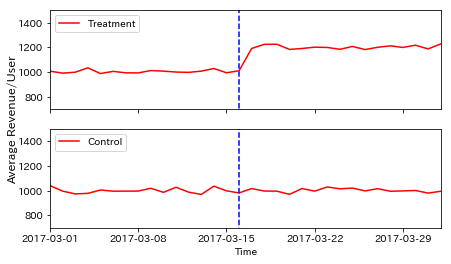

In [2]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 4))
ax1.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--')
ax1.plot(x, y + y_change, 'r-', label='Treatment')
ax1.set_ylim(700, 1500)
ax2.plot(x, y2, 'r-', label='Control')
ax1.legend(loc='upper left')
ax2.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--')
ax2.set_ylim(700, 1500)
plt.xlabel('Time')
ax1.set_xlim(x[0], x[-1])
ax2.set_xlim(x[0], x[-1])
fig.text(0.04, 0.5, 'Average Revenue/User', va='center', rotation='vertical', fontsize=12)
plt.legend(loc='upper left')
plt.show()

## 7.3 仮説検定の枠組み
### 7.3.2 コインは歪んでいるか

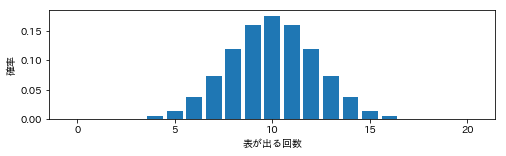

In [3]:
x = np.arange(0, 21)
y = scipy.stats.binom.pmf(x, 20, 0.5)

plt.figure(figsize=(8, 2))
plt.bar(x, y)
plt.xlabel('表が出る回数')
plt.ylabel('確率')
plt.show()

In [5]:
p_value = pd.DataFrame({'表の出る回数':x, '確率':y}).query('表の出る回数 >= 15')['確率'].sum()
print(p_value)
print('{:,.4f}'.format(p_value))

0.02069473266601554
0.0207


### 7.3.3 獲得ユーザーの継続利用率の比較

Sample A: size=205, converted=40, mean=0.195
Sample B: size=290, converted=62, mean=0.214


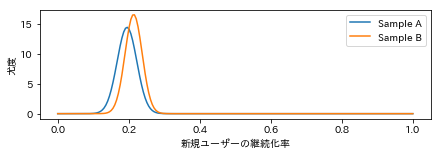

In [8]:
# テストデータ。継続化人数, 離脱人数
a = {'n_success': 40, 'n_observation': 205, 'p': 40/205}
b = {'n_success': 62, 'n_observation': 290, 'p': 62/290}
   
print(f'Sample A: size={a["n_observation"]}, converted={a["n_success"]}, mean={a["p"]:.3f}')
print(f'Sample B: size={b["n_observation"]}, converted={b["n_success"]}, mean={b["p"]:.3f}')

x = np.linspace(0, 1, 200)

def calc_err(data):
    p = data['p']
    n = data['n_observation']
    return np.sqrt(p * (1 - p) / n)

# 流入元がAの標本
y_a = scipy.stats.norm.pdf(x, a['p'], calc_err(a))

# 流入元がBの標本
y_b = scipy.stats.norm.pdf(x, b['p'], calc_err(b))

plt.figure(figsize=(7, 2))
plt.plot(x, y_a, label='Sample A')
plt.plot(x, y_b, label='Sample B')
plt.legend(loc='best')
plt.xlabel('新規ユーザーの継続化率')
plt.ylabel('尤度')
plt.show()

In [9]:
# カイ二乗検定
_, p_value, _, _ = scipy.stats.chi2_contingency([
    [a['n_success'], a['n_observation'] - a['n_success']],
    [b['n_success'], b['n_observation'] - b['n_success']]
])
print(p_value)

0.694254736449


### 7.3.4 差の信頼区間を求める

In [10]:
def calc_combined_err(a, b, alpha):
   p_a = a['p']
   n_a = a['n_observation']
   p_b = b['p']
   n_b = b['n_observation']
   z = scipy.stats.norm.ppf(1 - alpha / 2)
   return z * np.sqrt(p_a * (1 - p_a) / n_a + p_b * (1 - p_b) / n_b)

def calc_diff_confidence_interval(a, b, alpha):
   err = calc_combined_err(a, b, alpha)
   diff = a['p'] - b['p']
   return (diff - err, diff + err)

calc_diff_confidence_interval(a, b, alpha=0.05)

(-0.090570049430754834, 0.053227744973227492)

### 7.3.6 p値ハック

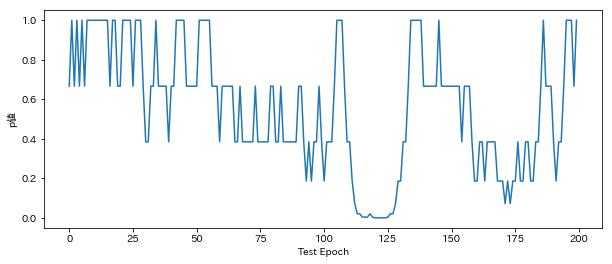

In [13]:
np.random.seed(34)
mu = 0.5 # 表が出る確率50%
init_sample = list(scipy.stats.bernoulli.rvs(mu, size=20))

sample = init_sample
p_value_history = []
for i in range(200):
    # 直近20回の結果を使って検定
    _, p_value = scipy.stats.ttest_1samp(sample[-20:], 0.5)
    p_value_history.append(p_value)
    # 新たにコインを投げて結果を保持
    sample.append(scipy.stats.bernoulli.rvs(mu))

plt.figure(figsize=(10, 4))
plt.plot(p_value_history)
plt.xlabel('Test Epoch')
plt.ylabel('p値')
plt.show()

## 7.4 A/Bテストの設計と実施

E(Y0) = 0.0517142857143
E(Y1) = 0.0657142857143


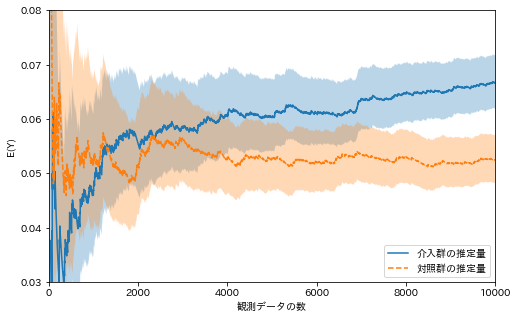

In [14]:
np.random.seed(4)
T = 14000

control = scipy.stats.binom(1, 0.05).rvs(size=T)
print('E(Y0) =', np.mean(control))
treatment = scipy.stats.binom(1, 0.065).rvs(size=T)
print('E(Y1) =', np.mean(treatment))

n_observed = np.ones(T).cumsum().astype(int)
treatment_p = treatment.cumsum() / n_observed
control_p = control.cumsum() / n_observed

import statsmodels.stats.proportion

@np.vectorize
def calc_confidence_interval(n_success, n_observed):
   return statsmodels.stats.proportion.proportion_confint(
      n_success, n_observed, alpha=0.05, method='wilson'
   )

treatment_lcb, treatment_ucb = calc_confidence_interval(treatment.cumsum(), n_observed)
control_lcb, control_ucb = calc_confidence_interval(control.cumsum(), n_observed)

fig = plt.figure(figsize=(8, 5))
plt.plot(n_observed, treatment_p, label='介入群の推定量')
plt.fill_between(n_observed, treatment_lcb, treatment_ucb, alpha=0.3, interpolate=True)
plt.plot(n_observed, control_p, linestyle='dashed',  label='対照群の推定量')
plt.fill_between(n_observed, control_lcb, control_ucb, alpha=0.3, interpolate=True)
plt.legend(loc='best')
plt.xlim(0, 10000)
plt.xlabel('観測データの数')
plt.ylabel('E(Y)')
plt.ylim(0.030, 0.08)
plt.show()

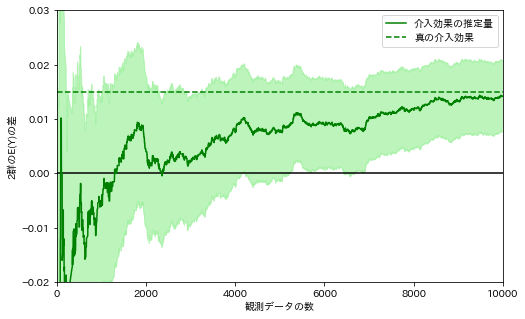

In [15]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

def _calc_diff_confidence_interval(n_success_a, n_success_b, n_observed):
   if n_observed < 10:
      return (1, -1)
   sample_a = DescrStatsW(np.append(np.ones(n_success_a), np.zeros(n_observed - n_success_a)))
   sample_b = DescrStatsW(np.append(np.ones(n_success_b), np.zeros(n_observed - n_success_b)))
   lcb, ucb = CompareMeans(sample_a, sample_b).zconfint_diff(alpha=0.05)
   return float(lcb), float(ucb)
calc_diff_confidence_interval = np.vectorize(_calc_diff_confidence_interval, otypes=[np.float, np.float])

diff_interval_lcb, diff_interval_ucb = calc_diff_confidence_interval(
   treatment.cumsum(),
   control.cumsum(),
   n_observed
)

diff = treatment_p - control_p

xmax = 10000
fig = plt.figure(figsize=(8, 5))
plt.plot(n_observed, diff, color='green', label='介入効果の推定量')
plt.fill_between(n_observed, diff_interval_lcb, diff_interval_ucb, alpha=0.6, color='lightgreen', interpolate=True)
plt.hlines([0], 0, xmax, "black")
plt.hlines([0.015], 0, xmax, "green", linestyles='dashed', label='真の介入効果')
plt.ylim(-0.02, 0.03)
plt.ylabel('2群のE(Y)の差')
plt.xlabel('観測データの数')
plt.legend(loc='best')
plt.xlim(0, xmax)
plt.show()